# Package Import & Spark Setup

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import round, col, udf, max
from pyspark.sql import Row

In [2]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# Data scraping

### Scraping functions

In [3]:
class FetchError(Exception): ...
    
    
def fetch_page(url: str) -> requests.models.Response:
    ATTEMPTS = 5
    for _ in range(ATTEMPTS):
        response = requests.get(url)
        if response.status_code == 200:
            return response
    raise FetchError(f"Failed to retrieve the webpage '{url}'.")


def scrape_table(response: requests.models.Response, year: int) -> pd.DataFrame:
    TABLE_ID = 'per_game_stats'
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', id=TABLE_ID)
    if not table:
        raise FetchError(f"No table found with class '{TABLE_ID}'.")
      
    header_row = table.find('tr')
    columns_fetched = [cell.get_text(strip=True) for cell in header_row.find_all('th')]
    columns = ["PLAYER_ID", "season"] + columns_fetched[1:]

    table_data = []
    for row in table.find_all('tr'):
        row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
        season = f"{year - 1}/{year}"
        if row_data:
            player_id = row.find('td').get("data-append-csv")
            table_data.append([player_id, season] + row_data)
  
    df = pd.DataFrame.from_records(data=table_data, columns=columns)
    return df


def prepare_data(season_start: int, season_end: int) -> pd.DataFrame:
    url_template = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html" 
    season_dfs = []
    print("Data fetching started:")
    try:
        for year in tqdm(range(season_start, season_end + 1)):
            url = url_template.format(year)
            response = fetch_page(url)
            df = scrape_table(response, year)
            season_dfs.append(df)
    except FetchError as e:
        print(f"Fetching failed: {e}")
    else:
        full_df = pd.concat(season_dfs, axis=0)
        full_df.reset_index(drop=True, inplace=True)
        print("Success!")
        return full_df

### Call

In [4]:
raw_df = prepare_data(1980, 2024)

Data fetching started:


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]

Success!


In [5]:
df = spark.createDataFrame(raw_df)

# 10 best scorers in ascending order 

In [6]:
df1 = df.select("*")
df1 = df1.withColumn("record_PTS", col("PTS") * col("G"))
df1 = df1.groupBy(["Player_ID"]).agg({'record_PTS': 'sum', "Player": "last"})
df1 = df1.select([col("last(Player)").alias('NAME'), round(col("sum(record_PTS)"), 1).alias("TOTAL_PTS")])
df1 = df1.orderBy(col("TOTAL_PTS").desc()).limit(10)
df1 = df1.orderBy(col("TOTAL_PTS").asc())

Total number of points in the data set is approximatet -- that's why there are "partial points" below

In [7]:
df1.show()

+------------------+---------+
|              NAME|TOTAL_PTS|
+------------------+---------+
|Dominique Wilkins*|  28585.3|
|     Vince Carter*|  28627.2|
| Shaquille O'Neal*|  29432.7|
|   Carmelo Anthony|  30255.3|
|      Kevin Durant|  30289.2|
|    Dirk Nowitzki*|  31561.1|
|   Michael Jordan*|  32299.4|
|      Kobe Bryant*|  33633.3|
|      Karl Malone*|  36936.1|
|      LeBron James|  40472.9|
+------------------+---------+



# 3 points attempts in each season

### Transformations

In [8]:
df2 = df.select("*")
df2 = df2.withColumn("record_3PA", col("3PA") * col("G"))
df2 = df2.groupBy(["season"]).agg({'record_3PA': 'sum', "G": "sum"})
df2 = df2.withColumn("avg_3PA", round(col("sum(record_3PA)") / col("sum(G)"), 4))
df2 = df2.select([col("season"), col("avg_3PA")])

extract_numbers_udf = udf(lambda s: int(re.findall(r'/(\d+)', s)[0]), "int")
df2 = df2.withColumn("int_season", extract_numbers_udf("season"))
df2_vis = df2.orderBy("int_season").drop("int_season")

### Tabular

In [9]:
df2_vis.show(df2_vis.count())

+---------+-------+
|   season|avg_3PA|
+---------+-------+
|1979/1980| 0.2745|
|1980/1981| 0.2017|
|1981/1982| 0.2163|
|1982/1983| 0.2107|
|1983/1984| 0.2286|
|1984/1985|  0.296|
|1985/1986| 0.3224|
|1986/1987| 0.4468|
|1987/1988| 0.4915|
|1988/1989| 0.6241|
|1989/1990| 0.6295|
|1990/1991| 0.6926|
|1991/1992| 0.7309|
|1992/1993| 0.8612|
|1993/1994| 0.9496|
|1994/1995| 1.5207|
|1995/1996|  1.543|
|1996/1997| 1.6492|
|1997/1998| 1.2646|
|1998/1999| 1.2695|
|1999/2000| 1.3262|
|2000/2001| 1.2975|
|2001/2002| 1.4717|
|2002/2003| 1.4652|
|2003/2004| 1.4455|
|2004/2005| 1.5624|
|2005/2006| 1.5687|
|2006/2007| 1.6686|
|2007/2008| 1.7268|
|2008/2009| 1.8133|
|2009/2010| 1.7726|
|2010/2011| 1.8014|
|2011/2012|  1.734|
|2012/2013| 1.8765|
|2013/2014| 2.0439|
|2014/2015| 2.1199|
|2015/2016| 2.2483|
|2016/2017| 2.5373|
|2017/2018| 2.7083|
|2018/2019| 3.0334|
|2019/2020| 3.2111|
|2020/2021| 3.1735|
|2021/2022|  3.272|
|2022/2023|  3.244|
|2023/2024| 3.2246|
+---------+-------+



### Visualization

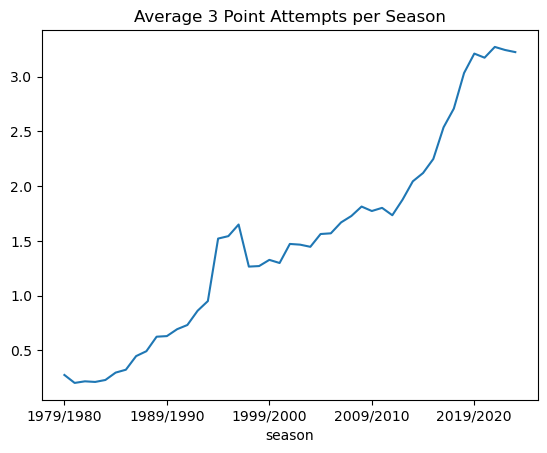

In [10]:
fig, ax = plt.subplots()

pd_df_plot = df2_vis
pd_df_plot.toPandas().plot.line(x="season", y="avg_3PA", ax=ax)
ax.get_legend().remove()
ax.set_title("Average 3 Point Attempts per Season")

plt.show()

# 3 point attempts prediction

### Preparing an extended table

In [11]:
PREDICTION_PERIOD = 5

In [12]:
max_year = df2.select(max(df2.int_season).alias("max")).take(1)[0].max
year_range = range(max_year + 1, max_year + 1 + PREDICTION_PERIOD)
new_rows = [Row(season=f"{year - 1}/{year}", avg_3PA=None, int_season=year) for year in year_range]
new_df = spark.createDataFrame(new_rows, schema=df2.schema)
df3 = df2.union(new_df)

In [13]:
assembler = VectorAssembler().setInputCols(['int_season']).setOutputCol('int_season_')
df3 = assembler.transform(df3)

In [14]:
df3_train = df3.filter(col("avg_3PA").isNotNull())

### Fitting the model

In [15]:
lr = LinearRegression(featuresCol="int_season_", labelCol="avg_3PA")
model = lr.fit(df3_train)

In [16]:
df3_res = model.transform(df3).withColumn("PRED_avg_3PA", round(col("prediction"), 4))
df3_res = df3_res.drop("prediction").drop("int_season_").orderBy("int_season")

In [17]:
df3_res_future = df3_res.filter(col("avg_3PA").isNull()).select([col("season"), col("PRED_avg_3PA")])

### Tabular

In [18]:
df3_res_future.show(PREDICTION_PERIOD)

+---------+------------+
|   season|PRED_avg_3PA|
+---------+------------+
|2024/2025|      3.0842|
|2025/2026|      3.1528|
|2026/2027|      3.2215|
|2027/2028|      3.2901|
|2028/2029|      3.3587|
+---------+------------+



### Visualization

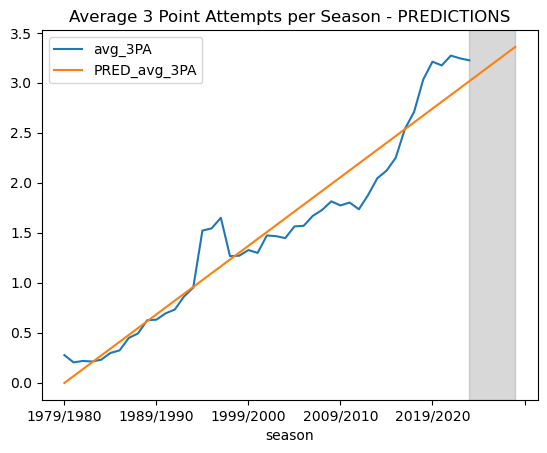

In [19]:
fig, ax = plt.subplots()

pd_df_plot = df3_res.toPandas()
pd_df_plot.plot.line(x="season", y=["avg_3PA", "PRED_avg_3PA"], ax=ax)
ax.set_title("Average 3 Point Attempts per Season - PREDICTIONS")

pred_area_filter = pd_df_plot[pd_df_plot.avg_3PA.isna()]
pred_area_ixs = [pred_area_filter.first_valid_index() - 1, pred_area_filter.last_valid_index()]
ax.axvspan(*pred_area_ixs, alpha=0.3, color='gray', zorder=-1)


plt.show()